In [1]:
%load_ext lab_black

# Historic Events

In this notebook we plot historic cold spells in Texas to show their intensity and duration.
We'll use the ERA5 data, for consistency with the "local_return_period" analysis.

In [2]:
import cartopy.crs as ccrs
from cartopy.feature import STATES, COASTLINE
from datetime import datetime, timedelta
import geopandas as gp
import matplotlib.pyplot as plt
import regionmask
import numpy as np
import xarray as xr

from codebase.path import datadir
from codebase.fig import smart_save, add_panel_text

We start by loading the data

In [3]:
DURATIONS = [1, 3, 5]
Xi, Xf = (-130, -70)
Yi, Yf = (25, 50)

In [4]:
temp = xr.open_dataset(datadir("processed", "era5", "conus", "daily_summaries.nc")).sel(
    latitude=slice(Yf, Yi), longitude=slice(Xi, Xf)
)["anomaly"]

In [5]:
temp_roll = xr.concat(
    [temp.rolling(time=dur).mean().assign_coords({"lag": dur}) for dur in DURATIONS],
    dim="lag",
).rename({"longitude": "lon", "latitude": "lat"})

Based on **subjective** exploratory analysis, reading newspapers and blogs, and looking at this data, we choose 4 historical events to plot, plust the 2021 cold snap.

In [6]:
EVENTS = [
    ["1951-02-02", "1951-02-02", "1951-02-03"],
    ["1983-12-25", "1983-12-26", "1983-12-26"],
    ["1989-12-23", "1989-12-24", "1989-12-24"],
    ["2011-02-02", "2011-02-04", "2011-02-06"],
    ["2021-02-16", "2021-02-17", "2021-02-17"],
]

We plot temperature anomalies

In [7]:
data_proj = ccrs.PlateCarree()
map_proj = ccrs.LambertConformal()
VMAX = 50
VMIN = -VMAX
CMAP = "RdBu_r"
plot_kw = dict(
    vmin=VMIN,
    vmax=VMAX,
    cmap=CMAP,
    add_colorbar=False,
    transform=data_proj,
)
contour_kw = dict(
    colors=["black"],
    add_colorbar=False,
    transform=data_proj,
    levels=np.linspace(VMIN, VMAX, int(np.ceil((VMAX - VMIN) / 10)) + 1),
    linewidths=0.5,
    linestyles="-",
)
contourf_kw = dict(
    cmap=CMAP,
    add_colorbar=False,
    transform=data_proj,
    levels=np.linspace(VMIN, VMAX, int(np.ceil((VMAX - VMIN) / 5)) + 1),
)

We apply a filter to show only data over land

In [8]:
land = regionmask.defined_regions.natural_earth.land_110
mask = land.mask(temp_roll)
temp_land = temp_roll.where(mask == 0)

/Users/jamesdoss-gollin/anaconda/envs/txtreme/lib/python3.7/site-packages/regionmask/core/regions.py:590: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


In [9]:
sdate = datetime.strptime(EVENTS[0][0], "%Y-%m-%d").date()

In [10]:
event = EVENTS[0]
row = 0

In [11]:
col = 0
dur = DURATIONS[0]
date = event[col]

In [12]:
temp_land.sel(time=date, lag=dur)

<xarray.DataArray 'anomaly' (lat: 26, lon: 56)>
array([[        nan, -11.954697 , -12.827201 , ...,  -5.5717926,
         -5.6768875,  -5.90135  ],
       [ -5.922247 ,  -7.1108875,         nan, ...,  -5.717985 ,
         -4.796795 ,  -4.4760046],
       [        nan,  -1.0987206,         nan, ...,  -8.496758 ,
         -4.6135216,  -4.399261 ],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
    time     datetime64[ns] 1951-02-02
  * lon      (lon) float32 -125.0 -124.0 -123.0 -122.0 ... -72.0 -71.0 -70.0
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 29.0 28.0 27.0 26.0 25.0
    season   object 'DJF'
    lag      int64 1

/Users/jamesdoss-gollin/anaconda/envs/txtreme/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/jamesdoss-gollin/anaconda/envs/txtreme/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/jamesdoss-gollin/anaconda/envs/txtreme/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Use

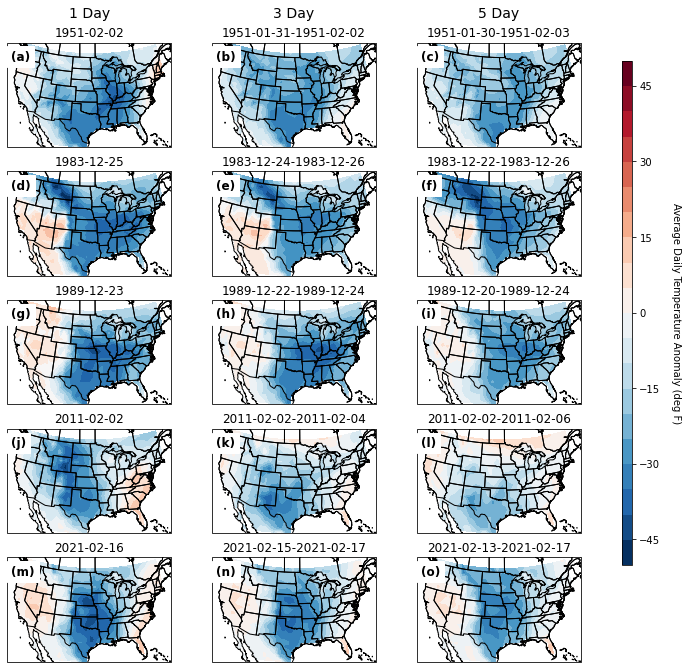

In [13]:
fig, axes = plt.subplots(
    nrows=len(EVENTS),
    ncols=len(DURATIONS),
    figsize=(10, 10),
    subplot_kw=dict(projection=map_proj),
    sharex=True,
    sharey=True,
)

for row, event in enumerate(EVENTS):
    for col, dur in enumerate(DURATIONS):
        ax = axes[row, col]
        date = event[col]

        if dur == 1:
            edate = datetime.strptime(date, "%Y-%m-%d").date()
            title = f"{edate}"
        else:
            edate = datetime.strptime(date, "%Y-%m-%d").date()
            sdate = edate - timedelta(days=dur - 1)
            title = f"{sdate}-{edate}"

        C0 = temp_land.sel(time=date, lag=dur).plot.contourf(ax=ax, **contourf_kw)
        ax.set_title(title)
        ax.add_feature(STATES)
        ax.add_feature(COASTLINE)

# Add  color bars
fig.canvas.draw()
fig.tight_layout()
fig.subplots_adjust(right=0.875, top=0.875)
add_panel_text(
    axes,
    xloc=0.025,
    yloc=0.925,
    backgroundcolor="white",
    fontsize=12,
)

# column headers
pad = 25
for ax, col in zip(axes[0, :], ["1 Day", "3 Day", "5 Day"]):
    ax.annotate(
        col,
        xy=(0.5, 1),
        xytext=(0, pad),
        xycoords="axes fraction",
        textcoords="offset points",
        size=14,
        ha="center",
        va="baseline",
    )

cax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(C0, cax=cax)
cbar.set_label("Average Daily Temperature Anomaly (deg F)", rotation=270)
cbar.ax.get_yaxis().labelpad = 20

smart_save("historic_events_era5")
plt.show()

One cool insight is that the 2011 storm was much less severe (over most of Texas) than some others we have witnessed in the historical record.
The 2021 storm strongly affected Oklahoma and North Texas.

## Just Texas

Now let's repeat this analysis but just over TX using the higher resolution data

In [14]:
tx_temp = xr.open_dataset(datadir("processed", "era5", "tx", "daily_summaries.nc"))[
    "anomaly"
]

In [15]:
tx_temp_roll = xr.concat(
    [tx_temp.rolling(time=dur).mean().assign_coords({"lag": dur}) for dur in DURATIONS],
    dim="lag",
).rename({"longitude": "lon", "latitude": "lat"})

In [16]:
tx_mask = land.mask(tx_temp_roll)
tx_temp_land = tx_temp_roll.where(tx_mask == 0)

/Users/jamesdoss-gollin/anaconda/envs/txtreme/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/jamesdoss-gollin/anaconda/envs/txtreme/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/jamesdoss-gollin/anaconda/envs/txtreme/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Use

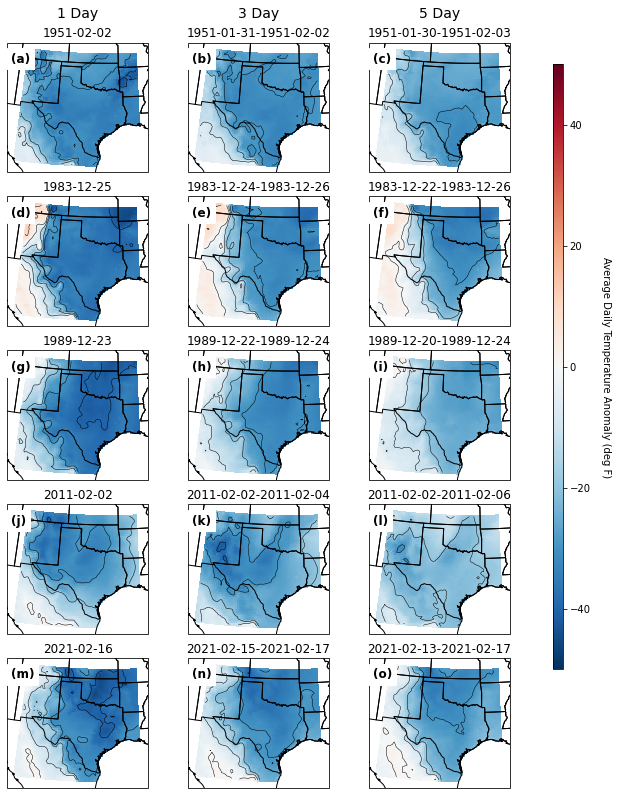

In [17]:
fig, axes = plt.subplots(
    nrows=len(EVENTS),
    ncols=len(DURATIONS),
    figsize=(9, 12),
    subplot_kw=dict(projection=map_proj),
    sharex=True,
    sharey=True,
)

for row, event in enumerate(EVENTS):
    for col, dur in enumerate(DURATIONS):
        ax = axes[row, col]
        date = event[col]

        if dur == 1:
            edate = datetime.strptime(date, "%Y-%m-%d").date()
            title = f"{edate}"
        else:
            edate = datetime.strptime(date, "%Y-%m-%d").date()
            sdate = edate - timedelta(days=dur - 1)
            title = f"{sdate}-{edate}"

        C0 = tx_temp_land.sel(time=date, lag=dur).plot(ax=ax, **plot_kw)
        tx_temp_land.sel(time=date, lag=dur).plot.contour(ax=ax, **contour_kw)
        ax.set_title(title)
        ax.add_feature(STATES)
        ax.add_feature(COASTLINE)

fig.canvas.draw()
fig.tight_layout()

fig.subplots_adjust(right=0.875, top=0.875)
add_panel_text(
    axes,
    xloc=0.025,
    yloc=0.925,
    backgroundcolor="white",
    fontsize=12,
)

# column headers
pad = 25
for ax, col in zip(axes[0, :], ["1 Day", "3 Day", "5 Day"]):
    ax.annotate(
        col,
        xy=(0.5, 1),
        xytext=(0, pad),
        xycoords="axes fraction",
        textcoords="offset points",
        size=14,
        ha="center",
        va="baseline",
    )

cax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(C0, cax=cax)
cbar.set_label("Average Daily Temperature Anomaly (deg F)", rotation=270)
cbar.ax.get_yaxis().labelpad = 20

smart_save("historic_events_era5_TX")
plt.show()

## Berkeley Earth

Repeat this analysis using Berkeley Earth data.
All variable names are preceded by `bk_`.
No additional explanation is given because it's all above!

In [18]:
bk_temp = xr.open_dataset(datadir("processed", "berkeleyearth", "TAVG.nc"))[
    "anomaly_f"
].sel(latitude=slice(Yi, Yf), longitude=slice(Xi, Xf))

In [19]:
bk_temp_roll = xr.concat(
    [bk_temp.rolling(time=dur).mean().assign_coords({"lag": dur}) for dur in DURATIONS],
    dim="lag",
).rename({"longitude": "lon", "latitude": "lat"})

In [20]:
bk_mask = land.mask(bk_temp_roll)
bk_temp_land = bk_temp_roll.where(bk_mask == 0)

We have different data ranges, so we can look at the 1899 event but not the 2021 event

In [21]:
bk_EVENTS = [
    ["1899-02-12", "1899-02-12", "1899-02-13"],  # 1 day, 3 day, 5 day
    ["1951-02-02", "1951-02-02", "1951-02-03"],
    ["1983-12-25", "1983-12-26", "1983-12-26"],
    ["1989-12-23", "1989-12-24", "1989-12-24"],
    ["2011-02-02", "2011-02-04", "2011-02-06"],
]

/Users/jamesdoss-gollin/anaconda/envs/txtreme/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/jamesdoss-gollin/anaconda/envs/txtreme/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/jamesdoss-gollin/anaconda/envs/txtreme/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Use

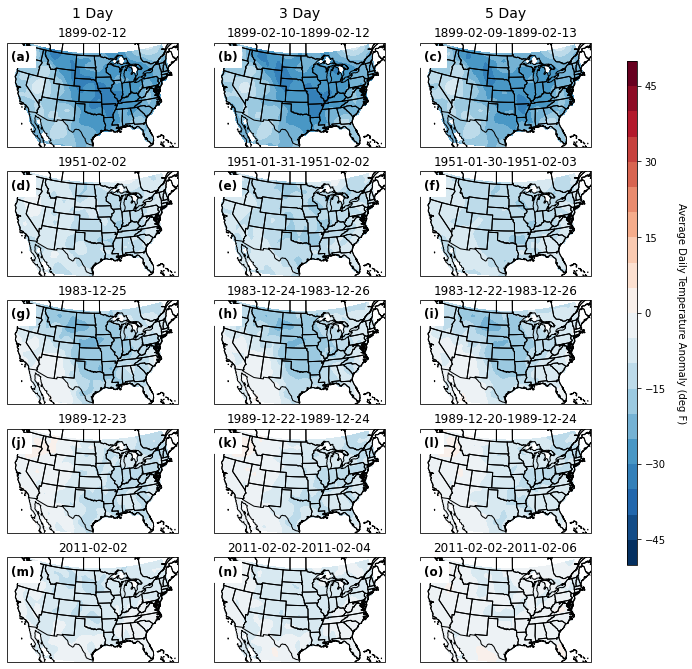

In [22]:
fig, axes = plt.subplots(
    nrows=len(bk_EVENTS),
    ncols=len(DURATIONS),
    figsize=(10, 10),
    subplot_kw=dict(projection=map_proj),
    sharex=True,
    sharey=True,
)

for row, event in enumerate(bk_EVENTS):
    for col, dur in enumerate(DURATIONS):
        ax = axes[row, col]
        date = event[col]

        if dur == 1:
            edate = datetime.strptime(date, "%Y-%m-%d").date()
            title = f"{edate}"
        else:
            edate = datetime.strptime(date, "%Y-%m-%d").date()
            sdate = edate - timedelta(days=dur - 1)
            title = f"{sdate}-{edate}"

        C0 = bk_temp_roll.sel(time=date, lag=dur).plot.contourf(ax=ax, **contourf_kw)
        ax.set_title(title)
        ax.add_feature(STATES)
        ax.add_feature(COASTLINE)

fig.canvas.draw()
fig.tight_layout()

fig.subplots_adjust(right=0.875, top=0.875)
add_panel_text(
    axes,
    xloc=0.025,
    yloc=0.925,
    backgroundcolor="white",
    fontsize=12,
)

# column headers
pad = 25
for ax, col in zip(axes[0, :], ["1 Day", "3 Day", "5 Day"]):
    ax.annotate(
        col,
        xy=(0.5, 1),
        xytext=(0, pad),
        xycoords="axes fraction",
        textcoords="offset points",
        size=14,
        ha="center",
        va="baseline",
    )

cax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(C0, cax=cax)
cbar.set_label("Average Daily Temperature Anomaly (deg F)", rotation=270)
cbar.ax.get_yaxis().labelpad = 20

smart_save("historic_events_bk")
plt.show()

Wow, that 1899 event looks to have been crazy!

We note that:

* Be extremely cautious when comparing across data sets
* Broad findings are similar between the two data sets
* We should interpret the 1899 event with great caution, as measurement protocols have changed somewhat (the Berkeley Earth data does attempt to account for this). However, the Great Blizzard of 1899 is a thing: https://en.wikipedia.org/wiki/Great_Blizzard_of_1899